In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint

# Load the data into NumPy arrays
faces_greyscale = np.load('/content/faces.npy')
print("faces.shape:", faces_greyscale.shape)
age_labels = np.load('/content/ages.npy')
print("ages.shape:", age_labels.shape)
# matrix = np.array([faces_greyscale, age_labels])

# # Select 80% of numbers randomly using np.random.choice
selected_numbers = np.random.choice(faces_greyscale.shape[0], size=int(0.8*(faces_greyscale.shape[0])), replace=False)
all_indices = np.arange(faces_greyscale.shape[0])
test_indices = np.setdiff1d(all_indices, selected_numbers)

faces_greyscale_trainval = faces_greyscale[selected_numbers]
age_labels_trainval = age_labels[selected_numbers]
# print(faces_greyscale_trainval.shape)
# print(age_labels_trainval.shape)
faces_rgb_trainval = np.repeat(faces_greyscale_trainval[..., np.newaxis], 3, axis = -1)
faces_rgb_trainval = faces_rgb_trainval.astype('float32') / 255.0

#Training
faces_rgb_train = faces_rgb_trainval[:5500]
age_labels_train = age_labels_trainval[:5500]

#Validation
faces_rgb_val = faces_rgb_trainval[5500:]
age_labels_val = age_labels_trainval[5500:]

#Test
faces_greyscale_test = faces_greyscale[test_indices]
age_labels_test = age_labels[test_indices]
faces_rgb_test = np.repeat(faces_greyscale_test[..., np.newaxis], 3, axis = -1)
faces_rgb_test = faces_rgb_test.astype('float32') / 255.0

print(faces_rgb_train.shape)
print(age_labels_train.shape)
print(faces_rgb_val.shape)
print(age_labels_val.shape)
print(faces_rgb_test.shape)
print(age_labels_test.shape)
# Creating a TensorFlow dataset from the NumPy arrays
dataset = tf.data.Dataset.from_tensor_slices((faces_rgb_trainval, age_labels_trainval))


faces.shape: (7500, 48, 48)
ages.shape: (7500,)
(5500, 48, 48, 3)
(5500,)
(500, 48, 48, 3)
(500,)
(1500, 48, 48, 3)
(1500,)


data: (6000, 48, 48, 3) labels: (6000,)
Age of this person is: 46


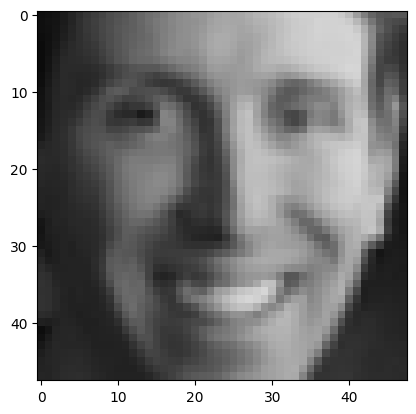

In [44]:
print("data:", faces_rgb_trainval.shape, "labels:", age_labels_trainval.shape)
plt.imshow(faces_rgb_train[1])
print("Age of this person is:", age_labels_train[1].astype('int'))

In [45]:
# input_shape = (224, 224, 3)
# num_classes = 1

# train_images = tf.image.resize(faces_rgb_train, (input_shape[0], input_shape[1]))
# val_images = tf.image.resize(faces_rgb_val, (input_shape[0], input_shape[1]))
# test_images = tf.image.resize(faces_rgb_test, (input_shape[0], input_shape[1]))

age_labels_train = age_labels_train.astype('float32')
age_labels_val = age_labels_val.astype('float32')
age_labels_test = age_labels_test.astype('float32')
print(faces_rgb_train.shape)
print(age_labels_train.shape)
print(age_labels_test.shape)

(5500, 48, 48, 3)
(5500,)
(1500,)


In [46]:
#Creating and training the Resnet50 model

#Loading the ResNet50 model from tensorflow
resnet_model = ResNet50(weights='imagenet', include_top = False, input_shape = (48,48,3))  
#Imagenet-using pretrainied weights, include_top-removing the last FC network to output a real number hence False

#Freexing the layers
for layer in resnet_model.layers:
  layer.trainable = False

#Replacing the last layer with a new dense layer to get a real number as an output
# x = Dense(1, activation='linear')(resnet_model.layers[-2].output)
# x = resnet_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256,activation='relu')(x)
# x = Dense(128,activation='relu')(x)
# x = Dense(1, activation='linear')(x)
x=Flatten()(resnet_model.output)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
x = Dense(1)(x)

#Creating a new model
model = Model(inputs=resnet_model.input, outputs=x)

#Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025), loss='mse', metrics=['mse'])
checkpointer = ModelCheckpoint(filepath='final_model.weights.best.hdf5', verbose=1, save_best_only=True)
#Training the model
history = model.fit(faces_rgb_train, age_labels_train, epochs = 30, batch_size = 32, validation_data=(faces_rgb_val, age_labels_val), callbacks=[checkpointer])

results = model.evaluate(faces_rgb_test, age_labels_test, batch_size=32)
print("Test RMSE = ", np.sqrt(results[1]))

Epoch 1/30
170/172 [============================>.] - ETA: 0s - loss: 316.4487 - mse: 316.4487
Epoch 1: val_loss improved from inf to 230.94365, saving model to final_model.weights.best.hdf5
172/172 [==============================] - 9s 27ms/step - loss: 315.1142 - mse: 315.1142 - val_loss: 230.9436 - val_mse: 230.9436
Epoch 2/30
171/172 [============================>.] - ETA: 0s - loss: 219.2391 - mse: 219.2391
Epoch 2: val_loss improved from 230.94365 to 223.43481, saving model to final_model.weights.best.hdf5
172/172 [==============================] - 4s 21ms/step - loss: 219.3547 - mse: 219.3547 - val_loss: 223.4348 - val_mse: 223.4348
Epoch 3/30
171/172 [============================>.] - ETA: 0s - loss: 213.1149 - mse: 213.1149
Epoch 3: val_loss did not improve from 223.43481
172/172 [==============================] - 3s 20ms/step - loss: 212.8770 - mse: 212.8770 - val_loss: 224.1610 - val_mse: 224.1610
Epoch 4/30
170/172 [============================>.] - ETA: 0s - loss: 208.9355